# imports

In [31]:
import pandas as pd
import numpy as np
import utils
import features

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import classifier

# Для отображения графиков
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

# data folder
data_folder = './data/'
file_name = 'concentrate.csv'

# constants
SEED = 1
DELTA_TIME = 128
CHUNK_SIZE = 8
SHIFT_TRAIN = 64
SHIFT_TEST = 64
verbose = 1

# Reading file and split for test/train

In [32]:
if verbose == 1:
    print('Reading file', data_folder + file_name, '\n')

# reading file
data = pd.read_csv(data_folder + file_name)
data['class'], class_dict = utils.encode_column(data['class'])

if verbose == 1:
    print('Creating train/test...')

# train test split
train, test = utils.eeg_train_test_split(data.to_numpy(), chunk_size=DELTA_TIME * CHUNK_SIZE,
                                         test_size=0.2, random_state=SEED)

if verbose == 1:
    print('train.shape', train.shape)
    print('test.shape', test.shape)

# creating 3d array from 2d
X_test, Y_test = utils.create_x_y(test, dt=DELTA_TIME, shift=SHIFT_TEST, verbose=0)
X_train, Y_train = utils.create_x_y(train, dt=DELTA_TIME, shift=SHIFT_TRAIN)

if verbose == 1:
    print('X_test.shape', X_test.shape)
    print('Y_test.shape', Y_test.shape)
    print('X_train.shape', X_train.shape)
    print('Y_train.shape', Y_train.shape)

Reading file ./data/concentrate.csv 

Creating train/test...
train.shape (52224, 16)
test.shape (13312, 16)
X_test.shape (195, 128, 14)
Y_test.shape (195,)
X_train.shape (765, 128, 14)
Y_train.shape (765,)


# Preprocessing

- Scale
- FFT
- Normalize

In [33]:
import preprocessing
from sklearn.pipeline import Pipeline
import torch_utils


preprocess_X = Pipeline(steps=[
    ('Scale', preprocessing.Scale()),
    ('Normalize', preprocessing.Normalize()),
    ('Transpose', preprocessing.Transpose())
])

preprocess_X_fft = Pipeline(steps=[
    ('Scale', preprocessing.Scale()),
    ('FFT', preprocessing.FFT()),
    ('Normalize', preprocessing.Normalize()),
    ('Transpose', preprocessing.Transpose()),
])

X_train_p = preprocess_X.fit_transform(X_train)
X_train_fft = preprocess_X_fft.fit_transform(X_train)

X_test_p = preprocess_X.transform(X_test)
X_test_fft = preprocess_X_fft.transform(X_test)
if verbose == 1:
    print('X_train_p.shape:', X_train_p.shape)
    print('X_train_fft.shape:', X_train_fft.shape)

X_train_p.shape: (765, 14, 128)
X_train_fft.shape: (765, 14, 65)


# Torch.

Creating datasets, loaders etc.

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if verbose == 1:
    print('Device:', device)
    print('Creatin datasets...')

datasets = torch_utils.create_dataset((X_train_p, X_train_fft), Y_train),\
           torch_utils.create_dataset((X_test_p, X_test_fft), Y_test)

if verbose == 1:
    print('Creating loaders...')

trn_dl, val_dl = torch_utils.create_loaders(datasets, bs=128)


Device: cuda:0
Creatin datasets...
Creating loaders...


In [35]:
raw_feat_number = X_train_p.shape[1]
fft_feat_number = X_train_fft.shape[1]
train_size = len(Y_train)

if verbose == 1:
    print('Raw feature number:', raw_feat_number)
    print('FFT feature number:', fft_feat_number)
    print('Train size:', train_size)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs * iterations_per_epoch

if verbose == 1:
    print('Learning rate:', lr)
    print('Max epochs:', n_epochs)
    print('Iterations per epoch:', iterations_per_epoch)
    print('Period:', period)

num_classes = 2
patience, trials = 500, 0
base = 1
step = 2

best_acc = 0
iteration = 0
loss_history = []
acc_history = []

model = classifier.Classifier(raw_feat_number, fft_feat_number, num_classes, drop = 0.5).to(device)

if verbose == 1:
    print('Creating model...')

criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)
sched = classifier.Scheduler(opt, partial(classifier.one_cycle, t_max=period, pivot=0.1))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        iteration += 1
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)  # update the learning rate
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()

    epoch_loss /= train_size
    loss_history.append(epoch_loss)

    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'model/' + 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

print('Done!')

Raw feature number: 14
FFT feature number: 14
Train size: 765
Learning rate: 0.001
Max epochs: 3000
Iterations per epoch: 6
Period: 18000
Creating model...
Start model training
Epoch:   1. Loss: 0.7011. Acc.: 46.15%
Epoch 1 best model saved with accuracy: 46.15%
Epoch:   2. Loss: 0.7053. Acc.: 46.15%
Epoch:   4. Loss: 0.7039. Acc.: 46.15%
Epoch:   8. Loss: 0.6971. Acc.: 46.15%
Epoch:  16. Loss: 0.6903. Acc.: 46.15%
Epoch:  32. Loss: 0.6805. Acc.: 46.15%
Epoch 56 best model saved with accuracy: 46.67%
Epoch 57 best model saved with accuracy: 47.18%
Epoch 58 best model saved with accuracy: 48.72%
Epoch 59 best model saved with accuracy: 49.74%
Epoch 60 best model saved with accuracy: 52.31%
Epoch 61 best model saved with accuracy: 53.85%
Epoch 62 best model saved with accuracy: 55.90%
Epoch 63 best model saved with accuracy: 57.95%
Epoch:  64. Loss: 0.5891. Acc.: 59.49%
Epoch 64 best model saved with accuracy: 59.49%
Epoch 65 best model saved with accuracy: 60.00%
Epoch 66 best model sav

In [36]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model.forward(X_batch.to(device)).float()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [37]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

Text(0, 0.5, 'Accuracy')

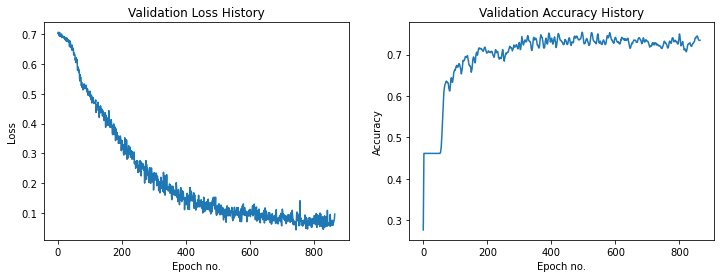

In [38]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')